In [1]:
import sys
from pathlib import Path

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

from model.kalman_heston_filter import kalman_like_heston_filter
from model.kalman_heston import kalman_like_heston_filter_2d
from model.Heston import *

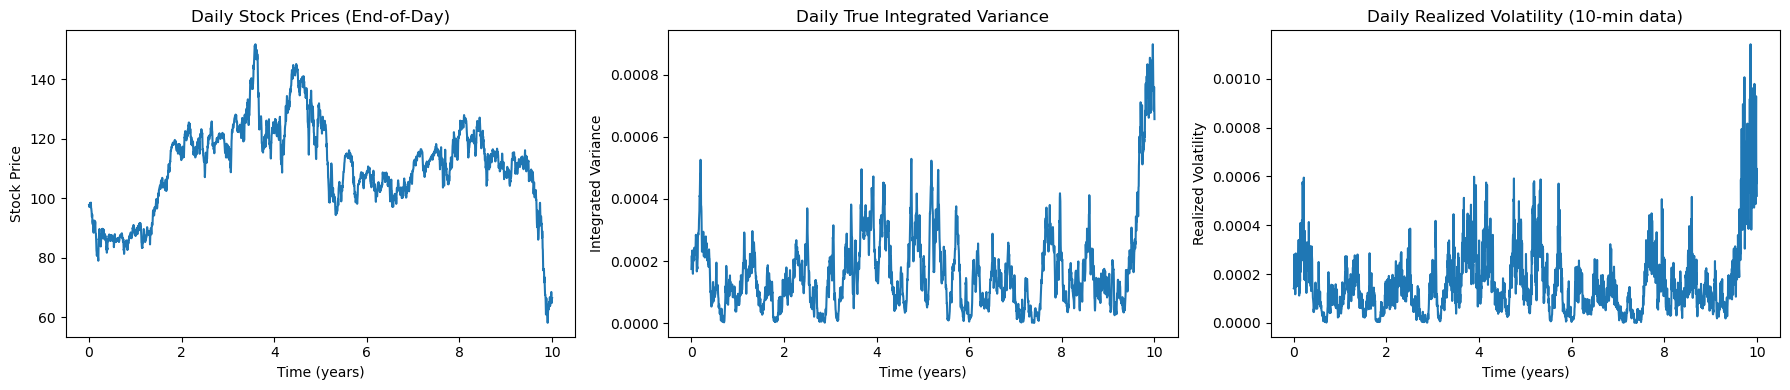

In [2]:
import numpy as np
import matplotlib.pyplot as plt

T_years = 10                   # Total simulation time in years
trading_days = 250             # Number of trading days per year
intraday_intervals = 39        # Number of 10-minute intervals per trading day (6.5 hours)
N = trading_days * T_years * intraday_intervals  # Total number of simulation steps (97,500)

T_vec, dt = np.linspace(0, T_years, int(N), retstep=True)

S0 = 100       # Initial stock price
v0 = 0.04      # Initial variance
mu = 0.05
rho = -0.8
kappa = 5
theta = 0.04
xi = 0.6    # (Alternative values: rho=-0.3, kappa=15, sigma=1)
std_asy = np.sqrt(theta * xi**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
assert 2 * kappa * theta > xi**2  # Feller condition

np.random.seed(seed=2)
Hest = Heston(mu=mu, rho=rho, xi=xi, theta=theta, kappa=kappa)
# Simulate high-frequency paths for stock (S_high) and variance (V_high)
S_high, V_high = Hest.path(S0, v0, int(N), T_years)

S_intraday = S_high.reshape(-1, intraday_intervals)   # Shape will be (2500, 39)
V_intraday = V_high.reshape(-1, intraday_intervals)     # Same, (2500, 39)

S_daily = S_intraday[:, -1]

daily_true_variance = V_intraday.sum(axis=1) * dt

log_returns_intraday = np.log(S_intraday[:, 1:] / S_intraday[:, :-1])
daily_realized_variance = (log_returns_intraday ** 2).sum(axis=1)
daily_realized_volatility = daily_realized_variance

time_daily = np.linspace(0, T_years, S_daily.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.plot(time_daily, S_daily)
ax1.set_title("Daily Stock Prices (End-of-Day)")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Stock Price")

ax2.plot(time_daily, daily_true_variance)
ax2.set_title("Daily True Integrated Variance")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Integrated Variance")

ax3.plot(time_daily, daily_realized_volatility)
ax3.set_title("Daily Realized Volatility (10-min data)")
ax3.set_xlabel("Time (years)")
ax3.set_ylabel("Realized Volatility")

plt.tight_layout()
plt.show()

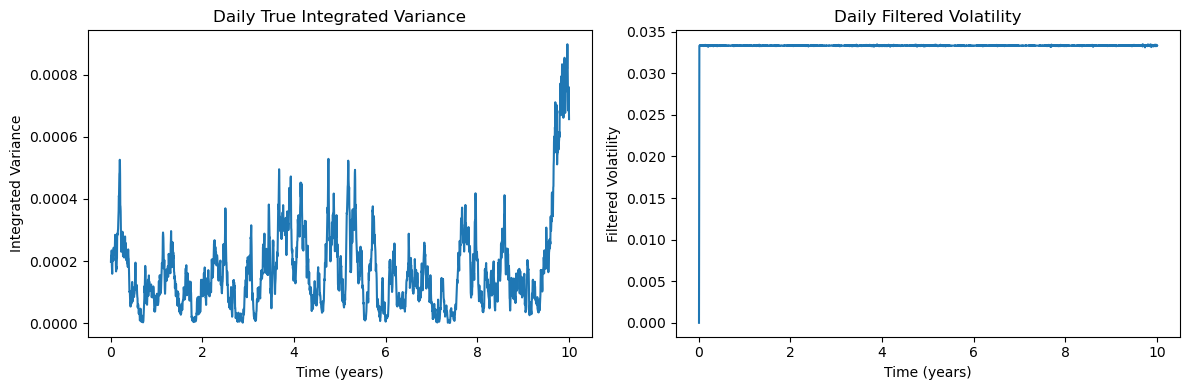

In [ ]:
# Calculate returns and realized volatility (excluding the first day)
R = np.diff(np.log(S_daily))
RV = daily_realized_volatility[1:]
true_variance = daily_true_variance[1:]

# Define parameters for the Kalman-like filter. Note: make sure xi is defined.
params = [mu, kappa, theta, xi, 1, rho, 0.8]

# Apply the Kalman-like Heston filter function
V_pred, P_pred, V_filt, P_filt = kalman_like_heston_filter_2d(
    params=params,
    R=R,
    RV=RV,
    V0=0,
    P0=0.01,
    dt=1
)

# Create two subplots: one for True Integrated Variance and one for Filtered Volatility.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Daily True Integrated Variance
ax1.plot(time_daily[1:], true_variance)
ax1.set_title("Daily True Integrated Variance")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Integrated Variance")

# Plot Daily Filtered Volatility (corrected from ax3 to ax2)
ax2.plot(time_daily[1:], V_filt)
ax2.set_title("Daily Filtered Volatility")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Filtered Volatility")

plt.tight_layout()
plt.show()


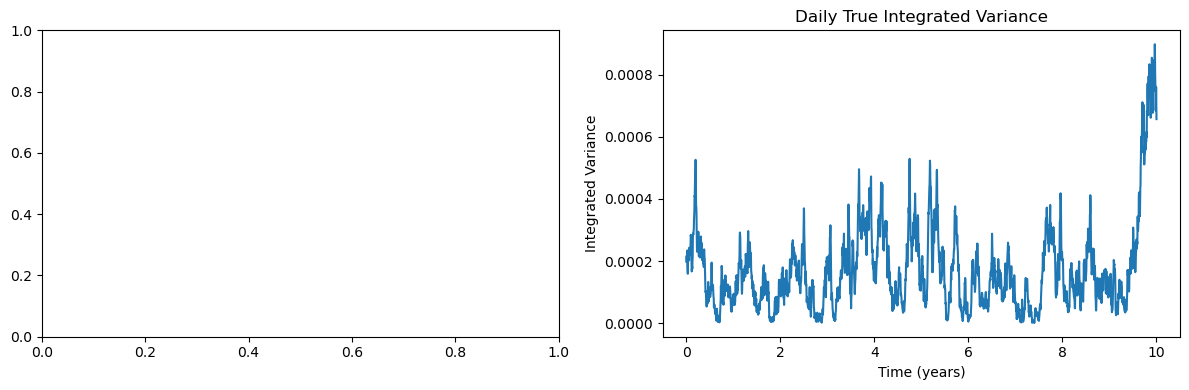